## Exploring the headroom counter stats from the default.cm table - 1.6

The purpose of this notebook is to explore counters data in the default.cm table of hive. Here we will mainly focus on the current_ops of the 'resource_headroom_cpu' object.

In [261]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns

from datetime import datetime

# this allows plots to appear directly in the notebook
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 200)
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.float_format', lambda x: '%.0f' % x)
plt.style.use('bmh')

### Importing the data

In [262]:
# Load headroom data for serial no 211645000176 from 31st May to 30th June, 2017
# Why 31 days of data is collected and not 30days I will explain later
'''
select cm.asup_key,
cm.instance_name,
cm.prev_time_stamp, cm.cur_time_stamp, 
split(cm.counters['current_ops'],'\\|')[1] as prev_ops,
split(cm.counters['current_ops'],'\\|')[0] as cur_ops,
split(cm.counters['current_latency'],'\\|')[1] as prev_latency,
split(cm.counters['current_latency'],'\\|')[0] as cur_latency,
split(cm.counters['current_utilization'],'\\|')[1] as prev_utilization,
split(cm.counters['current_utilization'],'\\|')[0] as cur_utilization,
split(cm.counters['current_utilization_total'],'\\|')[1] as prev_utilization_total,
split(cm.counters['current_utilization_total'],'\\|')[0] as cur_utilization_total,
cm.dt
from default.cm, guestdb.asup_last_asup_key
where cm.dt >= '2017-04-30' and cm.dt <= '2017-07-31' 
and split(cm.asup_key,'\\|')[3] = '601429000472'
and cm.object_name ='resource_headroom_cpu'
and asup_last_asup_key.asup_key = cm.asup_key
and asup_last_asup_key.dt = regexp_replace(cm.dt, "-", "")
and asup_last_asup_key.asup_type = 'DOT-PERF'
and asup_last_asup_key.asup_subject like '%PERFORMANCE DATA%'
order by cm.cur_time_stamp;
'''
headroom_601429000472_hive = pd.read_table('601429000472_system_utilization_join_cm_asup.tsv', 
                              header=None, na_values = ['null', 'NULL'],
                              names=["asup_key", "instance_name", "prev_time_stamp", "cur_time_stamp",  
                                     "prev_ops", "cur_ops","prev_latency", "cur_latency", 
                                     "prev_utilization", "cur_utilization",
                                     "prev_utilization_total","cur_utilization_total","dt"],
                             usecols=["asup_key", "instance_name", "prev_time_stamp", "cur_time_stamp",  
                                     "prev_utilization", "cur_utilization",
                                     "prev_utilization_total","cur_utilization_total","dt"],
                                     low_memory = 'False')

### Pre-processing the data

In [263]:
# checking COUNT of data
# for 93 days we are expecting 2232 (24 * (1 + 31 + 30 + 31)) records since the data is collected hourly. Count is not matching
len(headroom_601429000472_hive)

2231

In [264]:
# Missing data
24 * (1 + 31 + 30 + 31) - len(headroom_601429000472_hive)

1

In [265]:
# Check for duplicate records if any
headroom_601429000472_hive.duplicated().value_counts()

False    2231
dtype: int64

Fortunately, there are no duplicate records for this serial number.

In [266]:
# convert the cur_time_stamp to a more human readable format
headroom_601429000472_hive["cur_time_in_gmt"] = pd.to_datetime(headroom_601429000472_hive["cur_time_stamp"], unit='s')

In [267]:
# check for a specific column if it has null values
#headroom_601429000472_hive['prev_time_stamp'].isnull().values.any()
#headroom_601429000472_hive['cur_current_ops'].isnull().values.any()

In [268]:
# check for columns which have null values
headroom_601429000472_hive.isnull().sum()

asup_key                   0
instance_name              0
prev_time_stamp           93
cur_time_stamp             0
prev_utilization          93
cur_utilization            0
prev_utilization_total    93
cur_utilization_total      0
dt                         0
cur_time_in_gmt            0
dtype: int64

The prev_time_stamp, prev_current_ops have null values in 93 instances, beacuse we took the data for 93 days and the starting record for each day has prev_time_stamp, prev_current_ops as null in Hive table.

In [269]:
# truncate the minutes, that's not important, hourly data is important
headroom_601429000472_hive['cur_time_hourly'] = headroom_601429000472_hive['cur_time_in_gmt'].apply(lambda t: t.replace(minute=0, second=0))

In [270]:
headroom_601429000472_hive.set_index('cur_time_hourly', inplace=True)

In [271]:
headroom_601429000472_hive['hour'] = headroom_601429000472_hive.index.hour

In [272]:
headroom_601429000472_hive.head(10)

,asup_key,instance_name,prev_time_stamp,cur_time_stamp,prev_utilization,cur_utilization,prev_utilization_total,cur_utilization_total,dt,cur_time_in_gmt,hour
cur_time_hourly,,,,,,,,,,,
2017-04-29 08:00:00,C|BD812891-457D-11E4-B616-123478563412|8506464379|601429000472,1,NaN,1493452851,NaN,128045650982,NaN,2995319564064,2017-04-30,2017-04-29 08:00:51,8
2017-04-29 09:00:00,C|BD812891-457D-11E4-B616-123478563412|8506464379|601429000472,1,1.493453e+09,1493456451,1.280457e+11,128248725416,2.995320e+12,2998919619141,2017-04-30,2017-04-29 09:00:51,9
2017-04-29 10:00:00,C|BD812891-457D-11E4-B616-123478563412|8506464379|601429000472,1,1.493456e+09,1493460051,1.282487e+11,128590778650,2.998920e+12,3002519661763,2017-04-30,2017-04-29 10:00:51,10
2017-04-29 11:00:00,C|BD812891-457D-11E4-B616-123478563412|8506464379|601429000472,1,1.493460e+09,1493463651,1.285908e+11,128913318290,3.002520e+12,3006119697711,2017-04-30,2017-04-29 11:00:51,11
2017-04-29 12:00:00,C|BD812891-457D-11E4-B616-123478563412|8506464379|601429000472,1,1.493464e+09,1493467251,1.289133e+11,129109613366,3.006120e+12,3009719725475,2017-04-30,2017-04-29 12:00:51,12
2017-04-29 13:00:00,C|BD812891-457D-11E4-B616-123478563412|8506464379|601429000472,1,1.493467e+09,1493470851,1.291096e+11,129196190959,3.009720e+12,3013319778355,2017-04-30,2017-04-29 13:00:51,13
2017-04-29 14:00:00,C|BD812891-457D-11E4-B616-123478563412|8506464379|601429000472,1,1.493471e+09,1493474451,1.291962e+11,129281924863,3.013320e+12,3016919824549,2017-04-30,2017-04-29 14:00:51,14
2017-04-29 15:00:00,C|BD812891-457D-11E4-B616-123478563412|8506464379|601429000472,1,1.493474e+09,1493478051,1.292819e+11,129368661595,3.016920e+12,3020519865340,2017-04-30,2017-04-29 15:00:51,15
2017-04-29 16:00:00,C|BD812891-457D-11E4-B616-123478563412|8506464379|601429000472,1,1.493478e+09,1493481651,1.293687e+11,129453940672,3.020520e+12,3024119904818,2017-04-30,2017-04-29 16:00:51,16


In [273]:
median_values = pd.DataFrame(headroom_601429000472_hive.groupby(['instance_name', 'hour'])['prev_utilization', 'cur_utilization', 'prev_utilization_total', 'cur_utilization_total'].agg(np.median).reset_index())

In [274]:
median_values.head(15)

,instance_name,hour,prev_utilization,cur_utilization,prev_utilization_total,cur_utilization_total
0,1,0,1.797995e+11,1.798873e+11,4.215733e+12,4.219333e+12
1,1,1,1.798873e+11,1.799745e+11,4.219333e+12,4.222933e+12
2,1,2,1.799745e+11,1.800776e+11,4.222933e+12,4.226533e+12
3,1,3,1.800776e+11,1.801836e+11,4.226533e+12,4.230133e+12
4,1,4,1.801836e+11,1.802715e+11,4.230133e+12,4.233733e+12
5,1,5,1.802715e+11,1.803599e+11,4.233733e+12,4.237333e+12
6,1,6,1.803599e+11,1.804470e+11,4.237333e+12,4.240933e+12
7,1,7,1.804470e+11,1.805348e+11,4.240933e+12,4.244533e+12
8,1,8,NaN,1.774843e+11,NaN,4.161732e+12
9,1,9,1.774843e+11,1.776837e+11,4.161732e+12,4.165332e+12


### Post-processing the data

In [275]:
# calculate cpu_utilization_pctg
headroom_601429000472_hive['cpu_utilization_pctg'] = 100 * (headroom_601429000472_hive['cur_utilization'] - headroom_601429000472_hive['prev_utilization']) / (headroom_601429000472_hive['cur_utilization_total'] - headroom_601429000472_hive['prev_utilization_total'])

In [276]:
# Take a subset of data from 1st May to 30th July (31th July has data only till half day)
len(headroom_601429000472_hive['2017-05-01':'2017-07-30'])

2183

In [277]:
24 * (31 + 30 + 30)

2184

In [278]:
# missing data
24 * (31 + 30 + 30) - len(headroom_601429000472_hive['2017-05-01':'2017-07-30'])

1

In [279]:
true_index = pd.date_range(start='05/01/2017 00:00:00', end='07/30/2017 23:59:59', freq='H')

In [280]:
len(true_index)

2184

In [281]:
# Create an empty dataframe with ideal count of data that should have been present
df1 = pd.DataFrame(index=true_index)

In [282]:
# Take a subset of data from 1st May to 30th July
df2 = headroom_601429000472_hive['2017-05-01':'2017-07-30']

In [283]:
df_merged = df1.join(other=df2, how='outer')

In [284]:
len(df_merged)

2184

In [285]:
df_merged.columns

Index(['asup_key', 'instance_name', 'prev_time_stamp', 'cur_time_stamp',
       'prev_utilization', 'cur_utilization', 'prev_utilization_total',
       'cur_utilization_total', 'dt', 'cur_time_in_gmt', 'hour',
       'cpu_utilization_pctg'],
      dtype='object')

In [286]:
# just consider cpu_utilization_pctg column now, other columns are not needed
df_merged = df_merged['cpu_utilization_pctg']

In [287]:
df_merged.isnull().value_counts()

False    2092
True       92
Name: cpu_utilization_pctg, dtype: int64

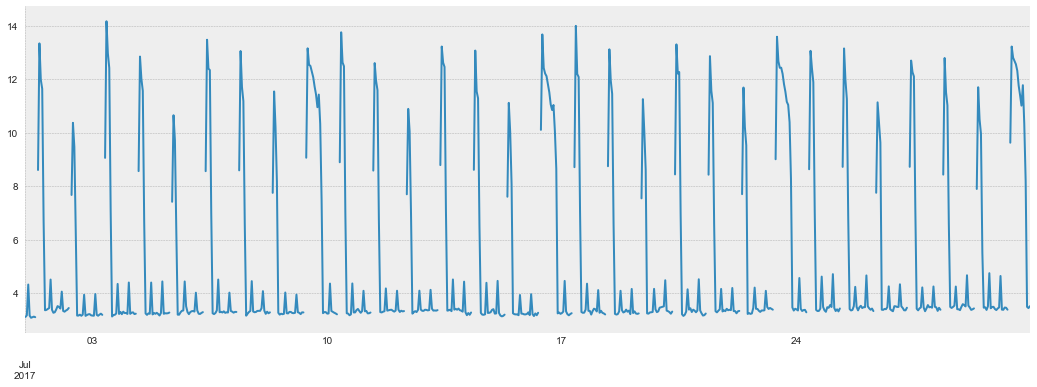

In [288]:
# 1 month
df_merged['2017-07-01':'2017-07-30'].plot(figsize=(18,6));

In the above graph we can see that there are breaks in the data becasue the starting record of each day has prev_utilization as null hence the cpu_utilization_pctg is also null.

In [289]:
# to fill the gaps we use forward fill strategy, if there is a gap it is filled with last hours value
df_ffill = df_merged.fillna(method='ffill')

In [290]:
df_ffill.isnull().value_counts()

False    2184
Name: cpu_utilization_pctg, dtype: int64

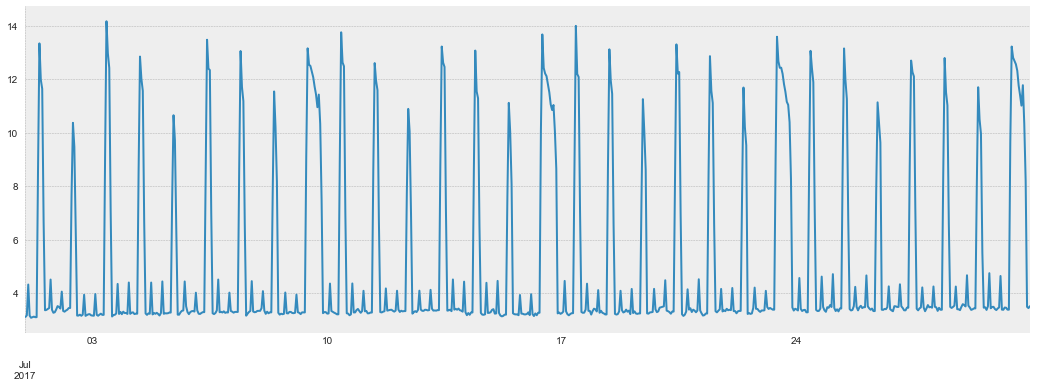

In [291]:
# 1 month
df_ffill['2017-07-01':'2017-07-30'].plot(figsize=(18,6));

In the above graph we can see that there is no break in the data now.

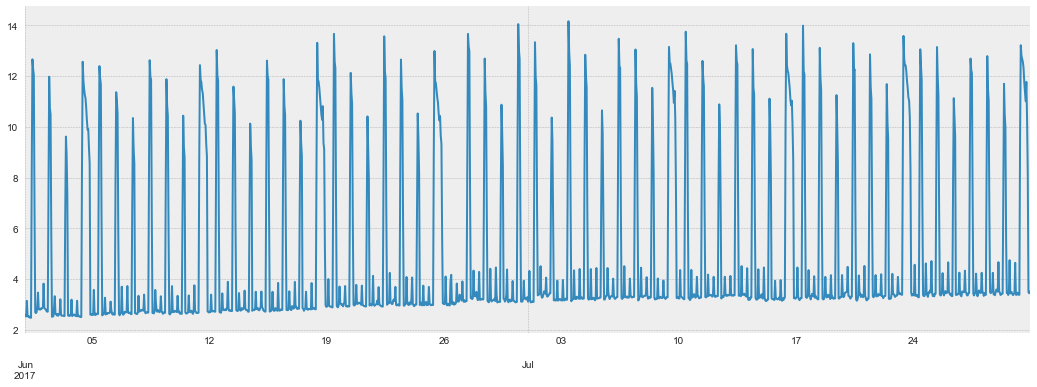

In [292]:
# 2 months
df_ffill['2017-06-01':'2017-07-30'].plot(figsize=(18,6));

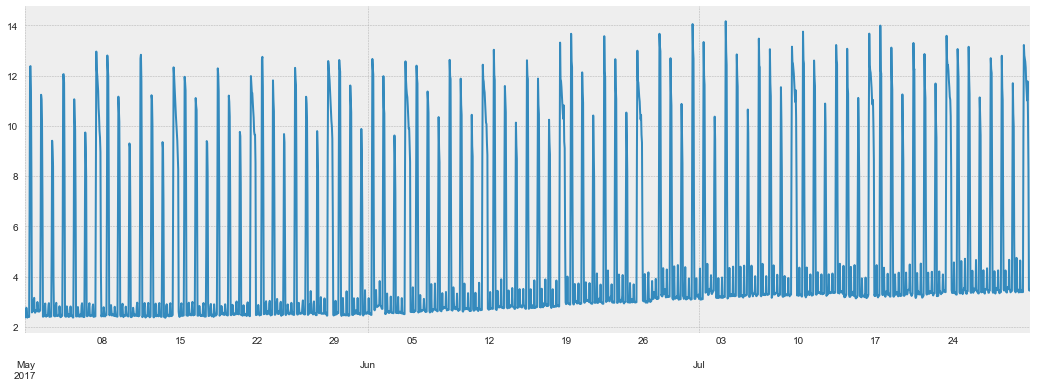

In [293]:
# 3 months
df_ffill['2017-05-01':'2017-07-30'].plot(figsize=(18,6));

### Resampling the data Monthly

#### Resampling for Daily Min(s)

In [294]:
# Resample: The 'D' string groups the data in daily by Day
df_daily_min = df_ffill.resample('D').min()
df_daily_min.head(5)

2017-05-01    2.368011
2017-05-02    2.405390
2017-05-03    2.403730
2017-05-04    2.385038
2017-05-05    2.373788
Freq: D, Name: cpu_utilization_pctg, dtype: float64

In [295]:
df_ffill['2017-05-01'].min()

2.3680114309677425

In [296]:
df_ffill['2017-05-04'].min()

2.3850380945781868

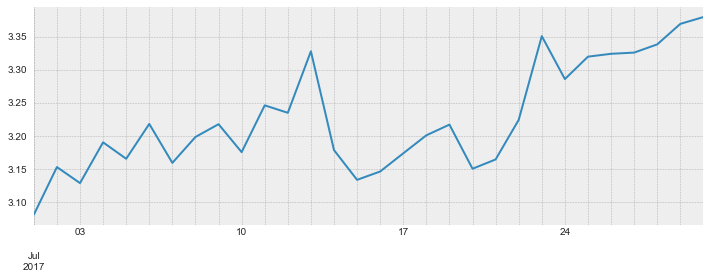

In [297]:
# 1 month trend for daily mins
ax = plt.gca()
df_daily_min['2017-07-01':'2017-07-30'].plot(figsize=(12,4));
ax.grid(True, which='both')
plt.show()

In [298]:
df_daily_min['2017-07-01']

3.0809439684337767

In [299]:
df_daily_min['2017-07-30']

3.3799006933271372

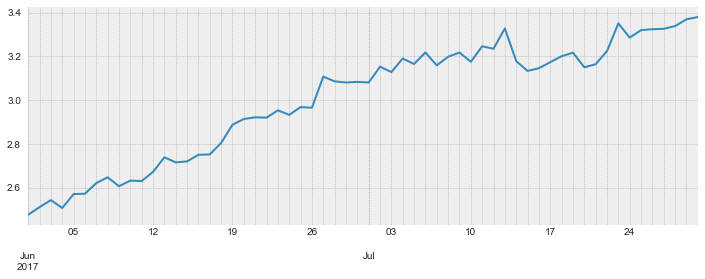

In [300]:
# 2 months trend for daily mins
ax = plt.gca()
df_daily_min['2017-06-01':'2017-07-30'].plot(figsize=(12,4));
ax.grid(True, which='both')
plt.show()

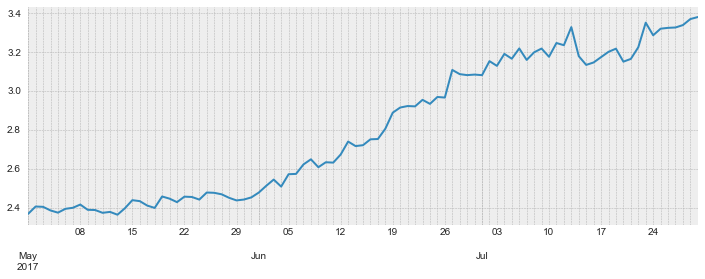

In [301]:
# 3 months trend for daily mins
ax = plt.gca()
df_daily_min['2017-05-01':'2017-07-30'].plot(figsize=(12,4));
ax.grid(True, which='both')
plt.show()

**Inference:**
+ The Daily Min is following a steady Upward Trend.

#### Resampling for Daily Max(s)

In [302]:
# Resample: The 'D' string groups the data in buckets by Day
df_daily_max = df_ffill.resample('D').max()
df_daily_max.head(5)

2017-05-01    12.381031
2017-05-02    11.239886
2017-05-03     9.410113
2017-05-04    12.060527
2017-05-05    11.060631
Freq: D, Name: cpu_utilization_pctg, dtype: float64

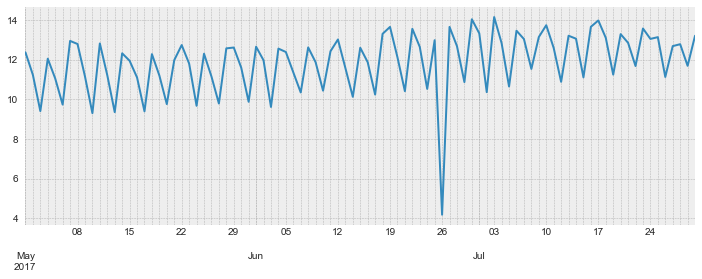

In [303]:
# 3 months trend for daily maxs
ax = plt.gca()
df_daily_max['2017-05-01':'2017-07-30'].plot(figsize=(12,4))
ax.grid(True, which='both')
plt.show()

**We can observe there is a sudden dip on 26th June**. Let's investigate further for 26th June.

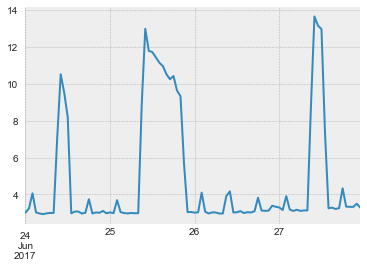

In [304]:
ax = plt.gca()
df_ffill['2017-06-24':'2017-06-27'].plot(ax=ax)
ax.grid(True, which='both')
plt.show()

**The regular pattern is missing on 26th June and hence the dip in max on that day**.

### Anomaly Detection using Rolling Mean and Standard Deviation

**Principle:** If the value at any time point is > 3 * standard_deviation then it is a significant deviation from norm and hence can be considered as anomaly.

In [305]:
window_size = 12
sigma=2
v_mean = df_daily_max.rolling(window_size).mean()
v_std = df_daily_max.rolling(window_size).std()

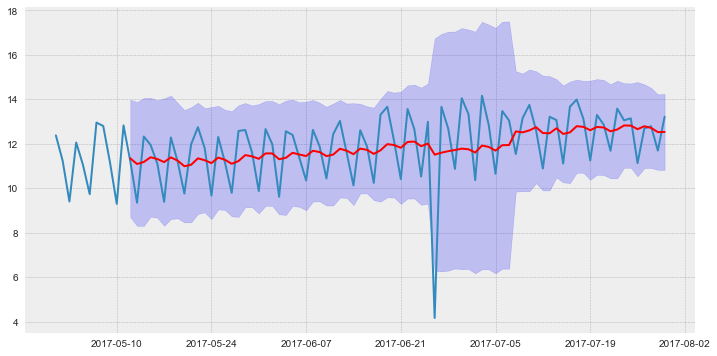

In [306]:
plt.figure(figsize=(12, 6))
plt.plot(df_daily_max.index, df_daily_max)
plt.plot(df_daily_max.index, v_mean, color='r')
plt.fill_between(df_daily_max.index, v_mean-sigma*v_std, v_mean+sigma*v_std, color='b', alpha=0.2)
plt.show()

### Simulate Anomaly on the Original cpu_utilization_pctg data

In [307]:
df_ffill_simulated = df_ffill.copy()

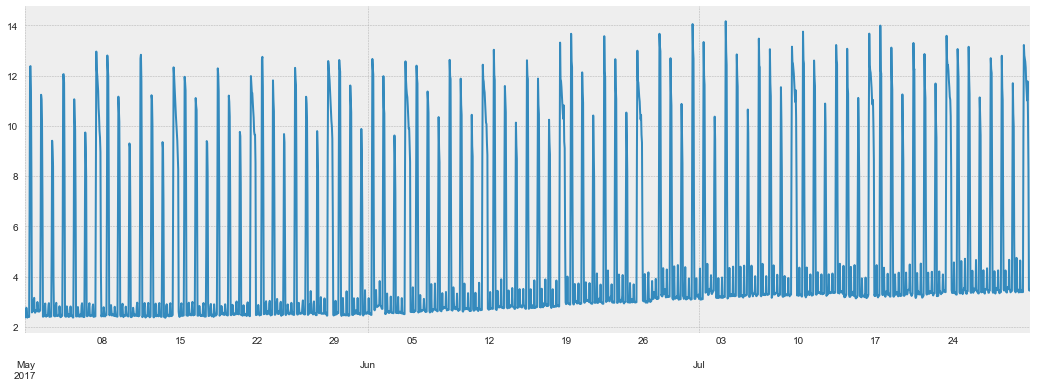

In [308]:
df_ffill_simulated.plot(figsize=(18,6));

#### Randomly pick some points and introduce anomaly

In [309]:
df_ffill_simulated.sample(5, random_state=23)

2017-07-08 17:00:00    3.227408
2017-05-05 04:00:00    2.431672
2017-06-19 22:00:00    3.004025
2017-07-12 18:00:00    4.094266
2017-05-31 10:00:00    9.879550
Name: cpu_utilization_pctg, dtype: float64

In [310]:
# Multiply the value by 5 for some random points
for index in df_ffill_simulated.sample(5, random_state=23).index:
    df_ffill_simulated[index] = df_ffill_simulated[index] * 5

In [311]:
df_ffill_simulated.sample(5, random_state=23)

2017-07-08 17:00:00    16.137040
2017-05-05 04:00:00    12.158362
2017-06-19 22:00:00    15.020124
2017-07-12 18:00:00    20.471332
2017-05-31 10:00:00    49.397752
Name: cpu_utilization_pctg, dtype: float64

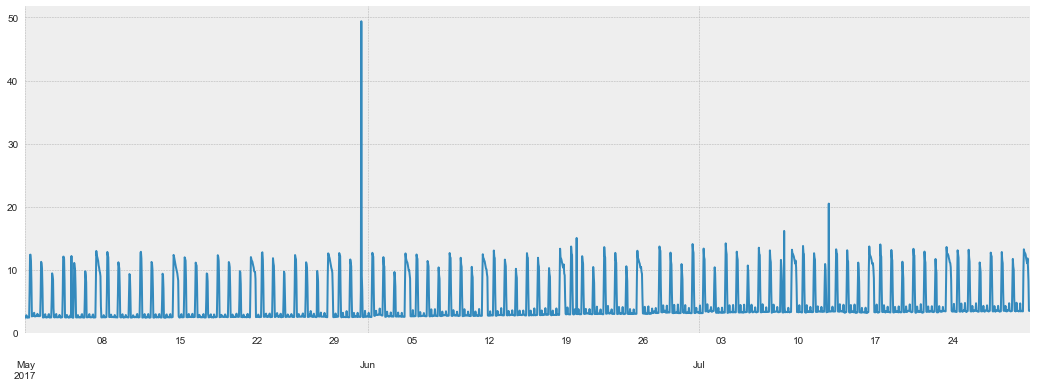

In [312]:
df_ffill_simulated.plot(figsize=(18,6));

#### Anomaly Detection using Rolling Moving Average and Standard Deviation on the Simulated Data

In [313]:
window_size = 12
sigma=2
v_mean = df_ffill_simulated.rolling(window_size).mean()
v_std = df_ffill_simulated.rolling(window_size).std()

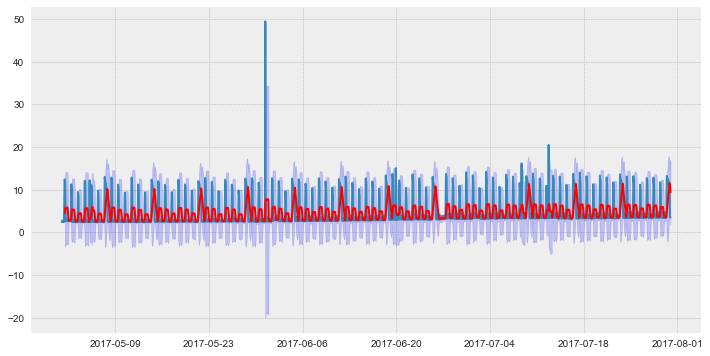

In [314]:
plt.figure(figsize=(12, 6))
plt.plot(df_ffill_simulated.index, df_ffill_simulated)
plt.plot(df_ffill_simulated.index, v_mean, color='r')
plt.fill_between(df_ffill_simulated.index, v_mean-sigma*v_std, v_mean+sigma*v_std, color='b', alpha=0.2)
plt.show()

In [315]:
anomaly_df = pd.DataFrame({'cpu_utilization_pctg':df_ffill_simulated, 'v_mean':v_mean, 'v_std':v_std}, index=df_ffill_simulated.index)
anomaly_df.head(3)

,cpu_utilization_pctg,v_mean,v_std
2017-05-01 00:00:00,2.378500,NaN,NaN
2017-05-01 01:00:00,2.425676,NaN,NaN
2017-05-01 02:00:00,2.762292,NaN,NaN


In [316]:
def is_anomaly(df):
    return True if df['cpu_utilization_pctg'] < df['v_mean']-sigma*df['v_std'] or df['cpu_utilization_pctg'] > df['v_mean']+sigma*df['v_std'] else False

In [317]:
anomaly_df['anomaly'] = anomaly_df.apply(is_anomaly, axis=1)
len(anomaly_df[anomaly_df['anomaly'] == True])

261

In [318]:
len(anomaly_df)

2184

#### Anomaly Detection using Simple Moving Average with numpy convolve and Standard Deviation on the Simulated Data

In [319]:
import collections
from itertools import count

window_size = 12
sigma=3

y = df_ffill_simulated.values

window = np.ones(int(window_size))/float(window_size)
y_av = np.convolve(y, window, 'same')
residual = y - y_av

# Calculate the variation in the distribution of the residual
std = np.std(residual)

anomalies_dict = collections.OrderedDict([(i, y_i) for i, y_i, avg_i in zip(count(), y, y_av) 
                                          if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])

x = list(range(len(y)))

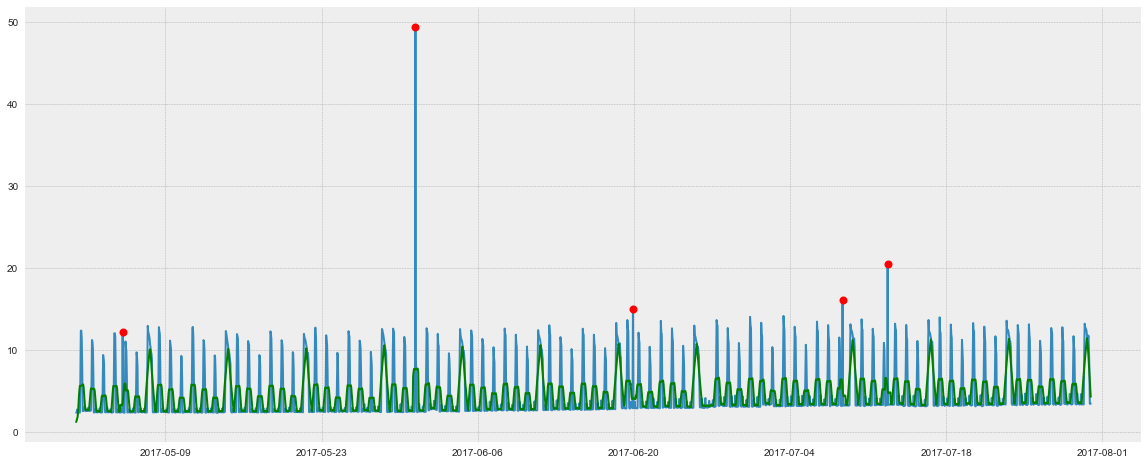

In [320]:
plt.figure(figsize=(20, 8))
plt.plot_date(x=df_ffill_simulated.index, y=y, fmt="-")
plt.plot_date(x=df_ffill_simulated.index, y=y_av, fmt="g-")
x_anomaly = [i for i in list(anomalies_dict.keys())]
y_anomaly = [v for v in list(anomalies_dict.values())]
plt.plot_date(x=df_ffill_simulated.index[x_anomaly], y=y_anomaly, fmt="ro", markersize=8)
# add grid and lines and enable the plot
plt.grid(True)
plt.show()

### Detecting Anomalies Using Twitter Anomaly Detection in R

In [321]:
# save the simulated data for R
df_ffill_simulated.reset_index().to_csv('601429000472_simulated_system_utilization.csv', header=['time', 'util_pctg'], index=False)

![601429000472_Anomaly_Rplot](images/601429000472_Anomaly_Rplot.png "601429000472_Anomaly_Rplot")

### Detecting Anomalies Which falls outside 5% and 95% of data grouped by hour

In [322]:
df_ffill_simulated_df = df_ffill_simulated.to_frame()
df_ffill_simulated_df['hour'] = df_ffill_simulated_df.index.hour

In [323]:
df_ffill_simulated_df.head(3)

,cpu_utilization_pctg,hour
2017-05-01 00:00:00,2.378500,0
2017-05-01 01:00:00,2.425676,1
2017-05-01 02:00:00,2.762292,2


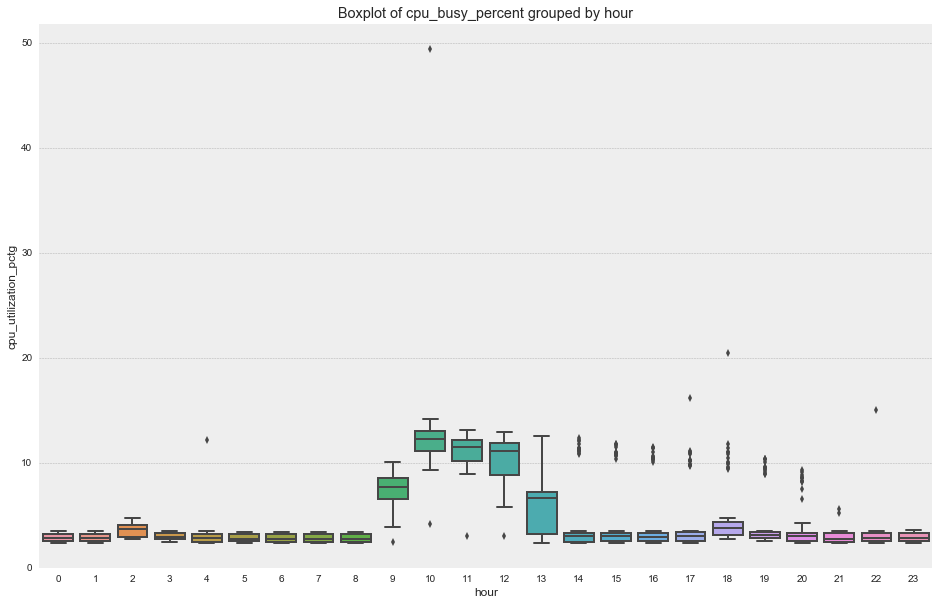

In [324]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.boxplot(x=df_ffill_simulated_df['hour'], y=df_ffill_simulated_df['cpu_utilization_pctg'], ax=ax)
ax.set_ylabel('cpu_utilization_pctg')
ax.set_title("Boxplot of cpu_busy_percent grouped by hour")
#plt.suptitle("") # get rid of the pandas autogenerated title

In [325]:
def get_percentile(df):
    # x is a DataFrame of group values
    df['1p'] = np.percentile(df['cpu_utilization_pctg'], 1)
    df['5p'] = np.percentile(df['cpu_utilization_pctg'], 5)
    #x['25p'] = np.percentile(x['preTestScore'], 25)
    #x['50p'] = np.percentile(x['preTestScore'], 50)
    #x['75p'] = np.percentile(x['preTestScore'], 75)
    df['95p'] = np.percentile(df['cpu_utilization_pctg'], 95)
    df['99p'] = np.percentile(df['cpu_utilization_pctg'], 99)
    return df

In [326]:
df_ffill_simulated_df = df_ffill_simulated_df.groupby('hour').apply(get_percentile)

In [327]:
df_ffill_simulated_df[df_ffill_simulated_df['hour']==0].head(5)

,cpu_utilization_pctg,hour,1p,5p,95p,99p
2017-05-01,2.378500,0,2.412228,2.431993,3.484809,3.554837
2017-05-02,2.667982,0,2.412228,2.431993,3.484809,3.554837
2017-05-03,2.445951,0,2.412228,2.431993,3.484809,3.554837
2017-05-04,2.469351,0,2.412228,2.431993,3.484809,3.554837
2017-05-05,2.415975,0,2.412228,2.431993,3.484809,3.554837


In [328]:
df_ffill_simulated_df[df_ffill_simulated_df['hour']==10].head(5)

,cpu_utilization_pctg,hour,1p,5p,95p,99p
2017-05-01 10:00:00,12.356243,10,8.789686,9.515275,13.713675,17.689657
2017-05-02 10:00:00,11.239886,10,8.789686,9.515275,13.713675,17.689657
2017-05-03 10:00:00,9.410113,10,8.789686,9.515275,13.713675,17.689657
2017-05-04 10:00:00,12.049312,10,8.789686,9.515275,13.713675,17.689657
2017-05-05 10:00:00,11.060631,10,8.789686,9.515275,13.713675,17.689657


In [329]:
def is_anomaly(df):
    return True if df['cpu_utilization_pctg'] < df['5p'] or df['cpu_utilization_pctg'] > df['95p'] else False

In [330]:
def is_anomaly2(df):
    return True if df['cpu_utilization_pctg'] < df['1p'] or df['cpu_utilization_pctg'] > df['99p'] else False

In [331]:
df_ffill_simulated_df['anomaly'] = df_ffill_simulated_df.apply(is_anomaly, axis=1)
df_ffill_simulated_df['anomaly2'] = df_ffill_simulated_df.apply(is_anomaly2, axis=1)
df_ffill_simulated_df.head(3)

,cpu_utilization_pctg,hour,1p,5p,95p,99p,anomaly,anomaly2
2017-05-01 00:00:00,2.378500,0,2.412228,2.431993,3.484809,3.554837,True,True
2017-05-01 01:00:00,2.425676,1,2.411213,2.425058,3.472207,3.505390,False,False
2017-05-01 02:00:00,2.762292,2,2.781665,2.805717,4.543588,4.674043,True,True


In [332]:
df_ffill_simulated_df['anomaly'].value_counts()

False    1944
True      240
Name: anomaly, dtype: int64

In [335]:
df_ffill_simulated_df['anomaly2'].value_counts()

False    2136
True       48
Name: anomaly2, dtype: int64

#### Plot with 95 percentile

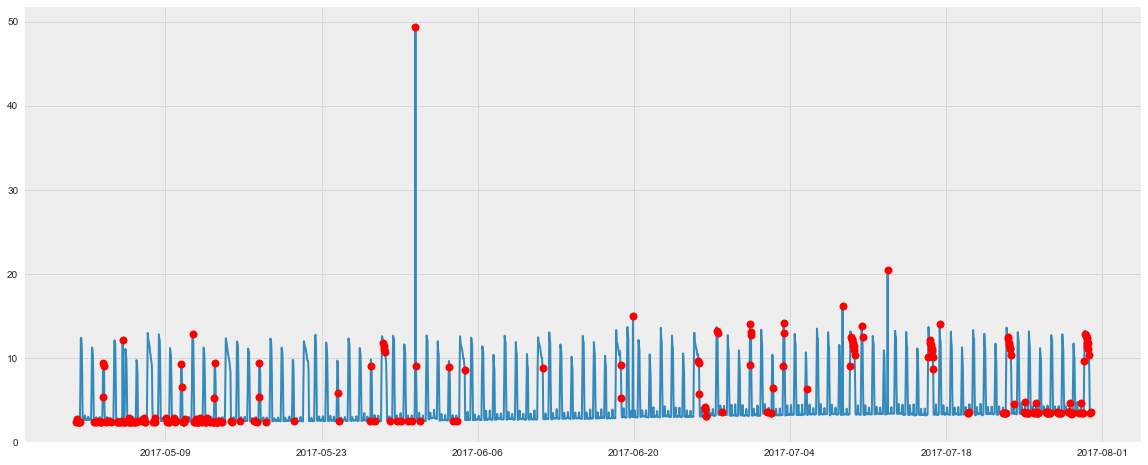

In [333]:
plt.figure(figsize=(20, 8))
plt.plot_date(x=df_ffill_simulated_df.index, y=df_ffill_simulated_df['cpu_utilization_pctg'], fmt="-")
#plt.plot_date(x=df_ffill_simulated.index, y=y_av, fmt="g-")
#x_anomaly = [i for i in list(anomalies_dict.keys())]
#y_anomaly = [v for v in list(anomalies_dict.values())]
df_ffill_anomaly_df = df_ffill_simulated_df[df_ffill_simulated_df['anomaly'] == True]
plt.plot_date(x=df_ffill_anomaly_df.index, y=df_ffill_anomaly_df['cpu_utilization_pctg'], fmt="ro", markersize=8)
# add grid and lines and enable the plot
plt.grid(True)
plt.show()

#### Plot with 99 percentile

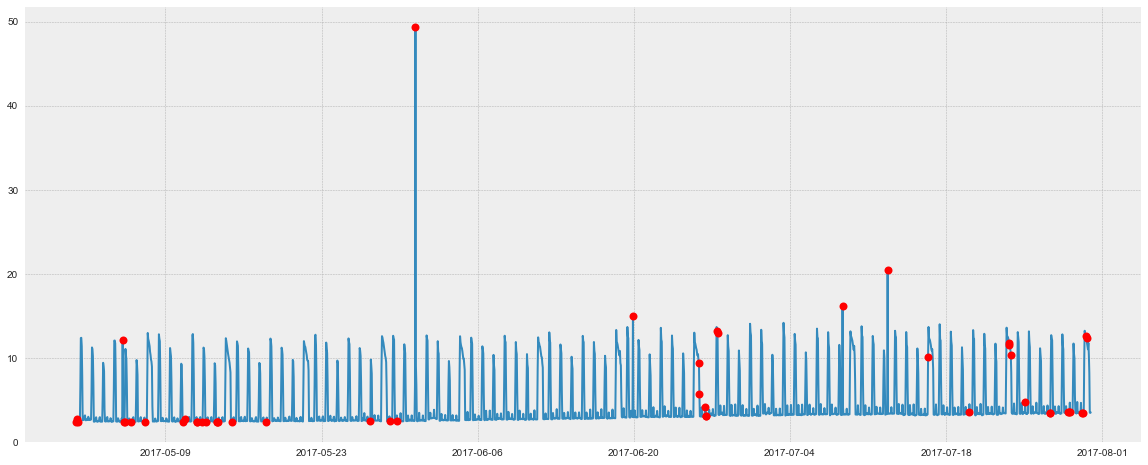

In [334]:
plt.figure(figsize=(20, 8))
plt.plot_date(x=df_ffill_simulated_df.index, y=df_ffill_simulated_df['cpu_utilization_pctg'], fmt="-")
#plt.plot_date(x=df_ffill_simulated.index, y=y_av, fmt="g-")
#x_anomaly = [i for i in list(anomalies_dict.keys())]
#y_anomaly = [v for v in list(anomalies_dict.values())]
df_ffill_anomaly_df = df_ffill_simulated_df[df_ffill_simulated_df['anomaly2'] == True]
plt.plot_date(x=df_ffill_anomaly_df.index, y=df_ffill_anomaly_df['cpu_utilization_pctg'], fmt="ro", markersize=8)
# add grid and lines and enable the plot
plt.grid(True)
plt.show()